# PCA-based EEG Artifact Removal

In this assignment, we'll generate synthetic multi-channel EEG data that includes alpha waves, blink artifacts, and muscle noise. You'll apply PCA (via SVD) to isolate and remove a blink-related component. Then you'll compare signals before and after cleaning using PSD and spectrogram analysis.

**Objectives**:
1. Generate realistic EEG-like data with random alpha activity, global blinks, and localized muscle artifacts.
2. Perform PCA (through SVD).
3. Detect the blink component more intelligently than simply removing the top PC.
4. Reconstruct signals without that component and observe improvements.
5. Estimate alpha peak frequency and amplitude before and after cleaning.

We split this assignment into several parts, each with tasks for partial credit.
Let's begin!

## Part 1: Setup and Imports

**Task**: Import the necessary libraries (NumPy, Matplotlib, `scipy.signal`) and set up basic parameters.
We'll define sampling rate, duration, number of channels, and so forth. We'll also create a directory for saving any plots if needed.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

np.random.seed(42) 
fs = 256
duration = 10.0  # we might later change this to 100.0
n_samples = int(fs * duration)
t = np.linspace(0, duration, n_samples)
n_channels = 8

os.makedirs('Figures', exist_ok=True)

print(f'Setup done: fs={fs}, duration={duration}, n_channels={n_channels}, n_samples={n_samples}')

Setup done: fs=256, duration=10.0, n_channels=8, n_samples=2560


## Part 2: Generate Synthetic EEG Data

Here, you'll simulate alpha waves plus blink and muscle artifacts.
1. Each channel has a random alpha frequency (8-12 Hz), amplitude (10-30), and random phase.
2. We add random noise.
3. Insert global blink artifacts (e.g., short triangular pulses).
4. Insert localized muscle artifacts in some channels.

Recall that after performing SVD (`centered_data = U Σ V^T`), each *column* of `U` is a “spatial pattern” for a principal component (PC). Because our rows are EEG channels arranged from front to back on the scalp, a PC that has **large values** in the front channels (e.g., channels 1–2) and **smaller values** in the rear channels (e.g., channels 7–8) probably corresponds to a **blink** (frontal) artifact. Thus, to detect the blink component, we compare the **average loading** in the front channels vs. the back channels for each PC. If a PC shows a big difference there, and also has a large singular value, we suspect it’s the blink component.

**Tips**:
- Define a function or do it inline.
- Keep track of the final data shape = (n_channels, n_samples).
- You may want to store blink times for reference.

In [2]:
# STUDENT TODO:
# 1) Create a data array of zeros, shape (n_channels, n_samples).
# 2) For each channel, generate alpha wave + noise.
# 3) Insert blink artifacts at random times.
# 4) Insert muscle bursts in a few channels.

data = np.zeros((n_channels, n_samples))

alpha_f_min, alpha_f_max = 8.0, 12.0
noise_level = 5.0

# Example partial solution (you can refine):
for ch in range(n_channels):
    f_alpha = np.random.uniform(alpha_f_min, alpha_f_max)
    alpha_amp = np.random.uniform(10.0, 30.0)
    alpha_phase = np.random.uniform(0, 2*np.pi)
    alpha_wave = alpha_amp * np.sin(2*np.pi*f_alpha * t + alpha_phase)
    noise = np.random.normal(0, noise_level, n_samples)
    data[ch] = alpha_wave + noise

# Blink artifact parameters
num_blinks = 5           # Total number of blink events
blink_width = 0.2        # Width of blink artifact in seconds
blink_amp_base = 50.0    # Base amplitude for the blink artifact
# Define scaling per channel (e.g., front channels get larger amplitudes than rear channels)
channel_scaling = np.linspace(1.0, 0.3, n_channels)

# Insert blink artifacts
blink_times = np.sort(np.random.uniform(1.0, duration - 1.0, num_blinks))
for bt in blink_times:
    center_idx = int(bt * fs)
    half_w = int(blink_width * fs / 2)
    for i in range(center_idx - half_w, center_idx + half_w):
        if 0 <= i < n_samples:
            dist = abs(i - center_idx)
            shape_amp = 1.0 - dist / half_w
            if shape_amp < 0.0:
                shape_amp = 0.0
            for ch in range(n_channels):
                data[ch, i] += blink_amp_base * channel_scaling[ch] * shape_amp

# Muscle artifact parameters
num_muscle = 3         # Number of channels to include muscle bursts
burst_duration = 0.5   # Duration of muscle burst in seconds
muscle_amp_base = 30.0 # Base amplitude for muscle artifacts

# Insert muscle artifacts
chosen_channels = np.random.choice(n_channels, size=num_muscle, replace=False)
for ch in chosen_channels:
    burst_time = np.random.uniform(1.0, duration - 1.0)
    burst_start = int(burst_time * fs)
    burst_len = int(burst_duration * fs)

    muscle_freq = np.random.uniform(20, 50)
    muscle_phase = np.random.uniform(0, 2*np.pi)
    for i in range(burst_len):
        idx = burst_start + i
        if 0 <= idx < n_samples:
            data[ch, idx] += muscle_amp_base * np.sin(2*np.pi*muscle_freq * t[idx] + muscle_phase)

print(f'Generated data shape: {data.shape}')

Generated data shape: (8, 2560)


## Part 3: Inspect Raw Signals

Plot the raw signals in a single figure, offsetting each channel so we can see them distinctly.
**Task**:
- Make a time-domain plot of all channels.
- Label axes, title.

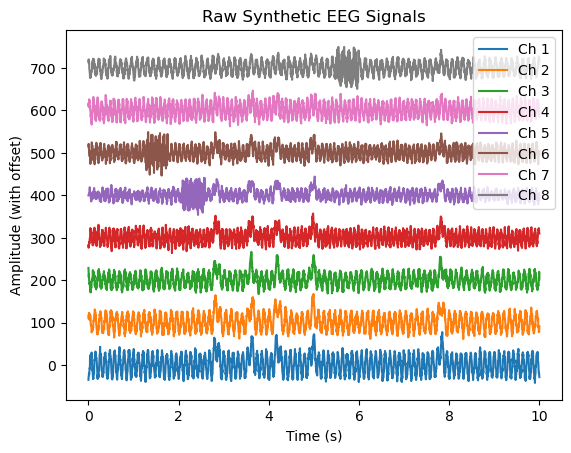

In [5]:
# Plot the data. Add offsets to each trace to make it visible. Label the axis and ticks appropriately
offset = 100.0

for ch in range(n_channels):
    plt.plot(t, data[ch] + ch*offset, label=f'Ch {ch+1}')

plt.title("Raw Synthetic EEG Signals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (with offset)")
plt.legend()
plt.show()

## Part 4: SVD-based PCA

We'll center the data, do an SVD, and interpret the singular values. Then we'll define a function to get principal components in the time domain.
**Tasks**:
1. Subtract each channel's mean.
2. Apply `np.linalg.svd`.
3. Plot singular values.
4. Write a function to produce PC time series = S diag * Vt.

Singular values: [1242.78539636 1024.70719574  877.4210327   793.79299569  714.92765115
  694.10954009  569.25450499  496.12072947]


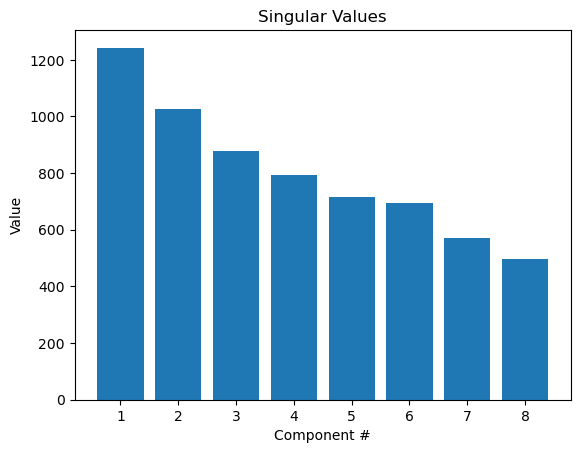

PC time series shape: (8, 2560)


In [6]:
data_centered = data - data.mean(axis=1, keepdims=True)

U, S, Vt = np.linalg.svd(data_centered, full_matrices=False)


print('Singular values:', S)
# Plot them
plt.figure()
plt.bar(range(1, len(S)+1), S)
plt.title('Singular Values')
plt.xlabel('Component #')
plt.ylabel('Value')
plt.show()

def get_pc_time_series(U, S, Vt):
    # S diag * Vt
    return np.diag(S) @ Vt

pc_time = get_pc_time_series(U, S, Vt)
print(f'PC time series shape: {pc_time.shape}')

## Part 5: Detect & Remove Blink Component

**Tasks**:
1. Write a function to identify the blink PC by looking at the top 3 singular values and the ratio of front vs. back channels in U.
2. Set that singular value to 0, reconstruct the data.
3. Plot the cleaned signals in time.

Detected blink component: 0


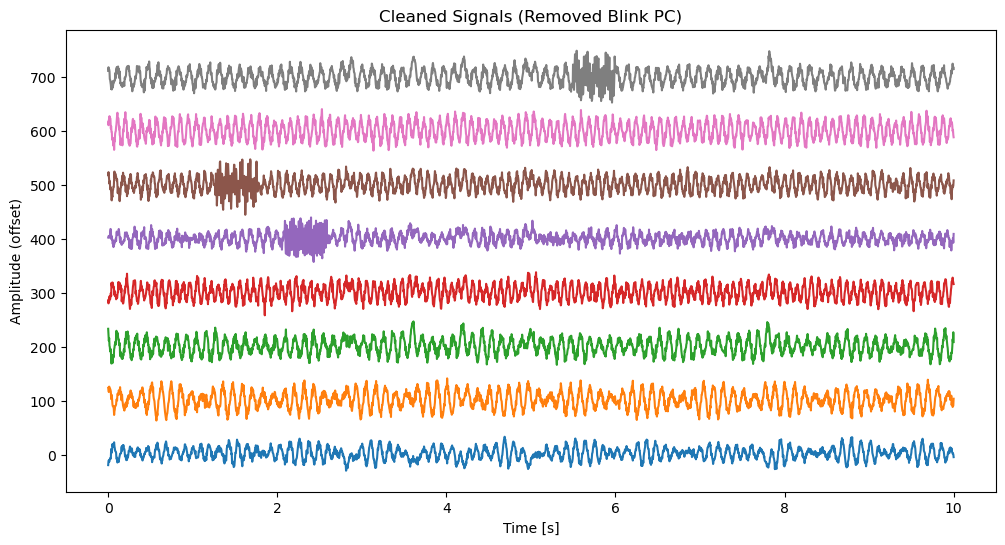

In [8]:
# STUDENT TODO:
# Example:
def detect_blink_component(U, S):
    front_idx = [0, 1]
    back_idx = [6, 7]
    
    # find indices for the top 3 singular values 
    top_indices = np.argsort(S)[-3:][::-1] 
    
    best_idx = None
    best_ratio = -np.inf
    for idx in top_indices:
        # compute average absolute loadings for front and back channels
        front_avg = np.mean(np.abs(U[front_idx, idx]))
        back_avg = np.mean(np.abs(U[back_idx, idx]))
        ratio = front_avg / (back_avg + 1e-8) # avoid division by zero
        if ratio > best_ratio:
            best_ratio = ratio
            best_idx = idx
            
    return best_idx

blink_comp_idx = detect_blink_component(U, S)
print(f'Detected blink component: {blink_comp_idx}')

def reconstruct_data(U, S, Vt, remove_list):
    S_mod = np.copy(S)
    S_mod[remove_list] = 0
    Sigma_mod = np.diag(S_mod)
    return U @ Sigma_mod @ Vt

mean_vals = data.mean(axis=1, keepdims=True)
clean_centered = reconstruct_data(U, S, Vt, [blink_comp_idx])
clean_data = clean_centered + mean_vals

# Plot the cleaned signals with offsets
plt.figure(figsize=(12,6))

for ch in range(n_channels):
    plt.plot(t, clean_data[ch] + ch*offset, label=f'Ch {ch+1}')
plt.title('Cleaned Signals (Removed Blink PC)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (offset)')
plt.show()

## Part 6: PSD & Spectrogram + Alpha Wave Parameter

**Tasks**:
1. Compute & plot PSD (via `welch`) for raw vs. cleaned signals.
2. Compute & plot spectrogram on at least one channel.
3. Estimate alpha frequency/amplitude (peak in 8-12 Hz) before & after cleaning,
   and print the results.

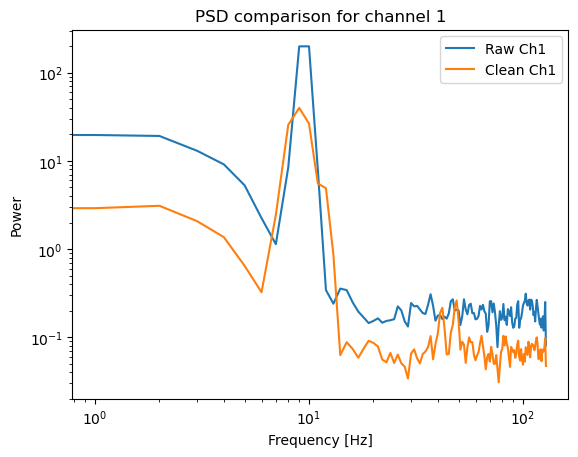

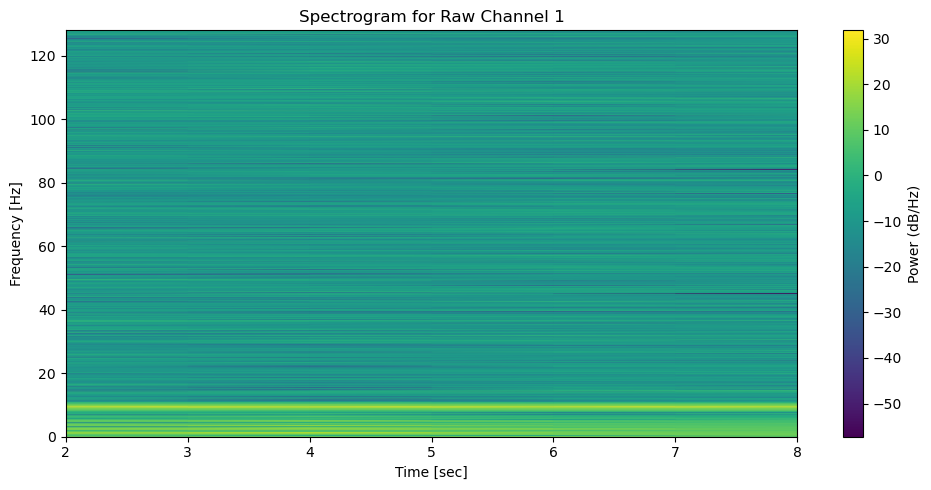

Alpha peak frequency and amplitude (Raw vs. Cleaned):
Channel 1:
  Raw   -> Peak frequency: 10.00 Hz, Amplitude: 199.70
  Clean -> Peak frequency: 9.00 Hz, Amplitude: 39.92
Channel 2:
  Raw   -> Peak frequency: 8.00 Hz, Amplitude: 160.77
  Clean -> Peak frequency: 8.00 Hz, Amplitude: 108.35
Channel 3:
  Raw   -> Peak frequency: 9.00 Hz, Amplitude: 91.87
  Clean -> Peak frequency: 9.00 Hz, Amplitude: 87.54
Channel 4:
  Raw   -> Peak frequency: 12.00 Hz, Amplitude: 108.52
  Clean -> Peak frequency: 12.00 Hz, Amplitude: 98.03
Channel 5:
  Raw   -> Peak frequency: 10.00 Hz, Amplitude: 33.62
  Clean -> Peak frequency: 10.00 Hz, Amplitude: 35.17
Channel 6:
  Raw   -> Peak frequency: 11.00 Hz, Amplitude: 80.02
  Clean -> Peak frequency: 11.00 Hz, Amplitude: 76.76
Channel 7:
  Raw   -> Peak frequency: 11.00 Hz, Amplitude: 147.81
  Clean -> Peak frequency: 11.00 Hz, Amplitude: 142.57
Channel 8:
  Raw   -> Peak frequency: 8.00 Hz, Amplitude: 95.98
  Clean -> Peak frequency: 8.00 Hz, Amplitude: 8

In [10]:
# PSD overlay
f_raw, p_raw = welch(data[0], fs=fs, nperseg=fs)
f_cln, p_cln = welch(clean_data[0], fs=fs, nperseg=fs)

plt.figure()
plt.plot(f_raw, p_raw, label='Raw Ch1')
plt.plot(f_cln, p_cln, label='Clean Ch1')
plt.xscale('log'); plt.yscale('log')
plt.title('PSD comparison for channel 1')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.show()

# Then do a spectrogram on channel 0, e.g.:
f_sp, t_sp, Sxx_raw = spectrogram(data[0], fs=fs, nperseg=1024, noverlap=512)
# Plot etc.
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_sp, f_sp, 10 * np.log10(Sxx_raw), shading='gouraud')
plt.title('Spectrogram for Raw Channel 1')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power (dB/Hz)')
plt.tight_layout()
# plt.savefig("Figures/spectrogram_raw_channel1.png")
plt.show()


# define a function to find alpha peak freq & amplitude.
# Then do it on each channel raw vs. cleaned, print results.
def find_alpha_peak(f, p, alpha_range=(8, 12)):
    indices = np.where((f >= alpha_range[0]) & (f <= alpha_range[1]))[0]
    if len(indices) == 0:
        return None, None
    alpha_freqs = f[indices]
    alpha_power = p[indices]
    
    peak_idx = np.argmax(alpha_power)
    peak_freq = alpha_freqs[peak_idx]
    peak_amp = alpha_power[peak_idx]
    return peak_freq, peak_amp

# Estimate Alpha Wave Parameters for Each Channel
print("Alpha peak frequency and amplitude (Raw vs. Cleaned):")
for ch in range(n_channels):
    # compute PSD for the raw and cleaned signals of each channel
    f_raw_ch, p_raw_ch = welch(data[ch], fs=fs, nperseg=fs)
    f_cln_ch, p_cln_ch = welch(clean_data[ch], fs=fs, nperseg=fs)
    
    alpha_peak_raw, alpha_amp_raw = find_alpha_peak(f_raw_ch, p_raw_ch)
    alpha_peak_cln, alpha_amp_cln = find_alpha_peak(f_cln_ch, p_cln_ch)
    
    print(f"Channel {ch+1}:")
    print(f"  Raw   -> Peak frequency: {alpha_peak_raw:.2f} Hz, Amplitude: {alpha_amp_raw:.2f}")
    print(f"  Clean -> Peak frequency: {alpha_peak_cln:.2f} Hz, Amplitude: {alpha_amp_cln:.2f}")